In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [9]:
#Caso esteja rodando este notebook no Colab, 
#uma forma de acessar os dados é rodar esta célula

#!git clone https://github.com/sutaina/aprendizadogeo.git

Cloning into 'aprendizadogeo'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 19 (delta 1), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (19/19), done.


# Picking automático usando K-means

Esta atividade é inspirada no trabalho de Waheed et al. 
https://doi.org/10.1190/segam2019-3215809.1

No resumo intitulado "Machine learning algorithms for automatic velocity picking: K-means vs. DBSCAN", os autores utilizam o algoritmo K-means para localizar centroides no painel de semblance. Vamos reproduzir esta ideia aqui.

O dado semblance.ascii é um painel de coerência de um 
dado sintético, com 4 camadas, gerado no Seismic Unix.

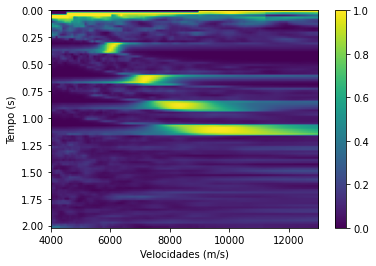

In [3]:
# Carregando e plotando o painel de semblance
dado = np.loadtxt("semblance.ascii") # Carregamos o dado

nt=101 #registros em tempo
nv=120 #velocidades
dado2=dado.reshape([nv,nt]) # Organizamos o dado em forma de matriz 

dt=0.02 #time shift
dv=75 #velocity shift
fv=4000 #primeira velocidade

plt.imshow(dado2.T,aspect="auto",extent=[fv, fv+nv*dv, nt*dt, 0])
plt.xlabel("Velocidades (m/s)")
plt.ylabel("Tempo (s)")
plt.colorbar()

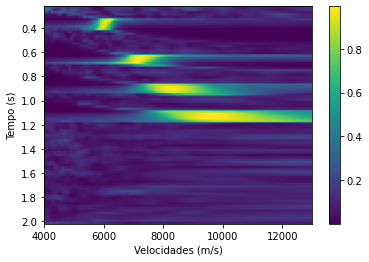

In [4]:
# Vamos mutar os primeiros segundos do painel, que não trazem informação relevante

dado_mute=dado2[:,10:-1]


plt.imshow(dado_mute.T,aspect="auto",extent=[fv, fv+nv*dv, nt*dt, 11*dt])
plt.xlabel("Velocidades (m/s)")
plt.ylabel("Tempo (s)")
plt.colorbar()

(120, 90) (120, 90)
(120, 90) (120, 90) (10800,)


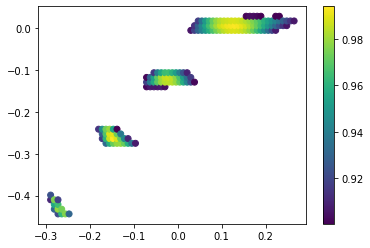

In [5]:
#Pre-processamento
#Vamos normalizar os dados para que as duas dimensões 
# (velocidade e tempo) fiquem na mesma escala
def standardise(vector):
    media = np.mean(vector)
    desvpad = np.std(vector)
    stand=(vector-media)/desvpad
    return stand

def normalise(vector):
    media = np.mean(vector)
    maxi = np.max(vector)
    mini = np.min(vector)
    norma = (vector - media)/(maxi-mini)
    return norma


t = np.arange(11*dt,nt*dt,dt)
v= np.arange(fv,fv+nv*dv,dv)

times,velocities=np.meshgrid(t,v)

timesN=normalise(times.flatten())
velocitiesN=normalise(velocities.flatten())
print(times.shape,velocities.shape)

# Vamos selecionar apenas aquelas semblances maiores que um determinado threshold
filtro=dado_mute.flatten()>0.9
dado_clean=dado_mute.flatten()
#dado_clean[filtro]=0

print(times.shape,velocities.shape,filtro.shape)

X=np.zeros([len(dado_clean[filtro]),3])
X[:,0]=timesN[filtro]
X[:,1]=velocitiesN[filtro]
X[:,2]=0*normalise(dado_clean[filtro])


plt.scatter(X[:,1],X[:,0],c=dado_clean[filtro])
plt.colorbar()


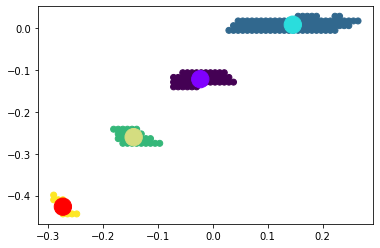

In [6]:
#Vamos calcular os centroides utilizando o k-means
from sklearn.cluster import KMeans
k=4
ctrds=np.zeros([k,3])
colors = cm.rainbow(np.linspace(0, 1, k)) # vou plotar cada centroide com uma cor
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)
pred_y = kmeans.fit_predict(X)

plt.scatter(X[:,1], X[:,0],c=pred_y)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:, 0], s=300, c=colors)

plt.show()

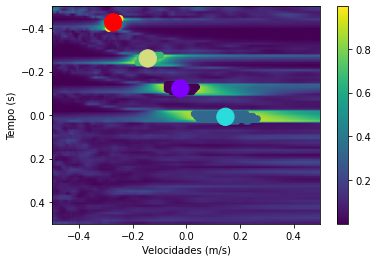

In [7]:
# E agora, vamos plotar os centroides sobre a imagem da semblance
clusters0 = np.zeros(dado_clean.shape)

clusters=clusters0.reshape([120,90])


dado_mute=dado2[:,10:-1]


plt.imshow(dado_mute.T,aspect="auto",extent=[min(velocitiesN), max(velocitiesN), max(timesN), min(timesN)])
plt.xlabel("Velocidades (m/s)")
plt.ylabel("Tempo (s)")
plt.colorbar()

plt.scatter(X[:,1], X[:,0],c=pred_y)
plt.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:, 0], s=300, c=colors)